# Capital Asset Pricing Model

By Beha Abasi, Maxwell Margenot, and Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [https://github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License. Please do not remove this attribution.

## The Different Types of Risk

In general, portfolios and assets can face two types of risk: idiosyncratic and systematic risk. The former refers to risks that are firm-specific and can be diversified away, such as a management change or a faulty production. Systematic risk is market-wide and affects all market participants. An example could be a slowing of the economy or a change in the interest rate. Because all firms are exposed to this type of risk, it can't be diversified away.

As the number of assets in a portfolio increases much of the idiosyncratic risks will cancel out and be diversified away. With large, diverse portfolios the variance will decline until there is only systematic risk left. Since we can't diversify away any more after this, investors must be given a risk premium above the rate of risk-free return to compensate them for this risk. Notice that firm-level risks don't result in a premium as this would create an arbitrage opportunity. Shareholders could collect the risk premium while diversifying away the risk. That would mean additional profit without any additional exposure. By definition, this would be an arbitrage opportunity!

From this we can gather that the premium on an asset should have no relation to its idiosyncratic risk, but should solely rely on the level of systematic risk it carries. What this suggests is that our usual measure of volatility, variance, is not especially useful in estimating value as it captures all fluctuations. In order to accurately compute the risk premium of an asset, and consequently our expected return, we need to find a measure of systematic risk. If we have that, then we can define the return of a stock in the following way:

   $$E[\mbox{Return}] = \mbox{Risk-Free Rate of Return} + \mbox{Risk Premium}$$

One way to do this is to estimate how changes in the excess return of an asset are related to changes in the excess return of the market. This is a classic case of linear regression. We define this relationship as the change in expected return of an asset for each 1% change in the return of the market portfolio, which is the portfolio of all stocks. In theory, this market portfolio should have no diversifiable risk left and would therefore only fluctuate with systematic shocks. In practice, we use a market index such as the S&P500 as a proxy for the market portfolio. The beta that we get from regressing a stock's returns on the returns of the market will be our measure of systematic risk. It will represent the sensitivity of a stock's underlying return streams to market-wide shocks. As such, we expect that stocks in more cyclical industries would have higher betas.

Given this beta, the risk premium of stock $i$ is defined as:

$$\mbox{Risk Premium of Stock} = \beta (\mbox{Market Risk Premium})$$

$$E[R_i] - R_F = \beta_i(E[R_M] - R_F)$$

where $R_i$ is the return of stock $i$, $R_F$ is the risk-free rate, and $R_M$ is the return of the market proxy.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     59.35
Date:                Wed, 21 Jun 2017   Prob (F-statistic):           3.12e-13
Time:                        18:06:25   Log-Likelihood:                 749.29
No. Observations:                 251   AIC:                            -1495.
Df Residuals:                     249   BIC:                            -1488.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                  0.0010      0.001      1.331      0.185        -0.000     0.003
Equity(8554 [SPY])     0.8438      0.110      7.704      0.000         0.628     1.059
==============================================================================
Omnibus:                       74.662   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2468.684
Skew:                          -0.320   Prob(JB):                         0.00
Kurtosis:                      18.351   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

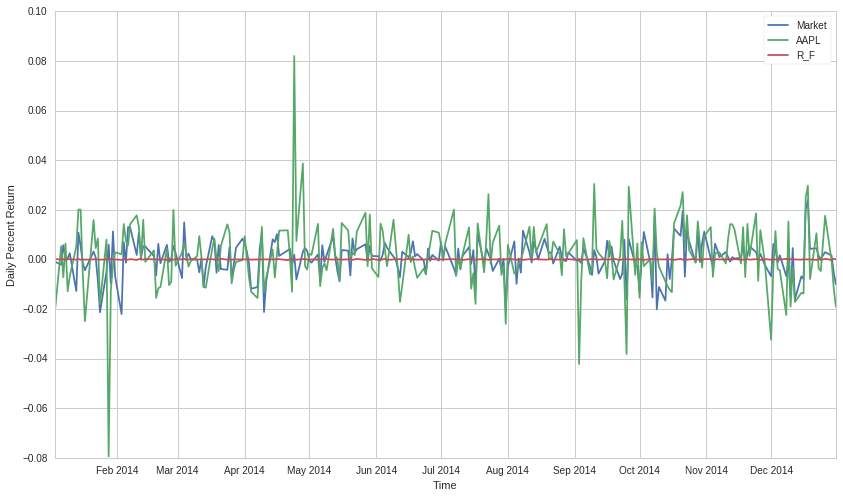

In [2]:
start_date, end_date = '2014-01-01', '2014-12-31'

# choose stock
R = get_pricing('AAPL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# risk-free proxy
R_F = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# find it's beta against market
M = get_pricing('SPY', start_date=start_date, end_date=end_date, fields='price').pct_change()[1:]

AAPL_results = regression.linear_model.OLS(R-R_F, sm.add_constant(M)).fit()
AAPL_beta = AAPL_results.params[1]

plt.plot(M.index, M.values)
plt.plot(R.index, R.values)
plt.plot(R_F.index, R_F.values)
plt.xlabel('Time')
plt.ylabel('Daily Percent Return')
plt.legend(['Market', 'AAPL', 'R_F'])

AAPL_results.summary()

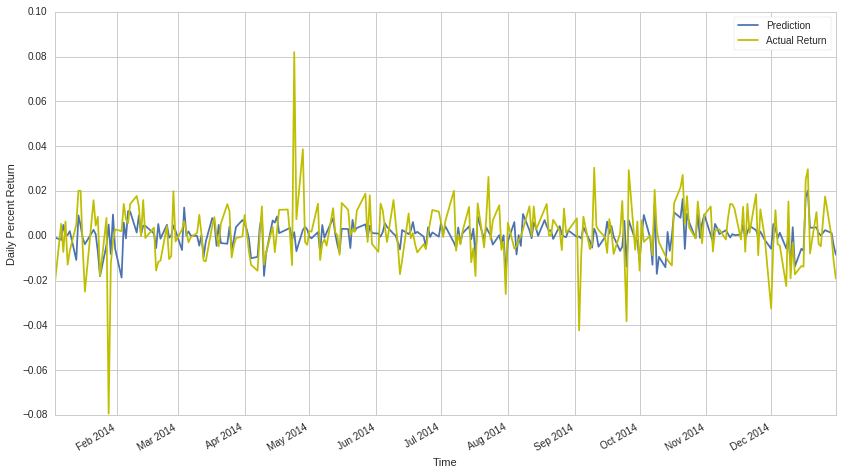

In [3]:
predictions = R_F + AAPL_beta*(M - R_F) # CAPM equation

predictions.plot()
R.plot(color='Y')
plt.legend(['Prediction', 'Actual Return'])

plt.xlabel('Time')
plt.ylabel('Daily Percent Return')

## Capital Asset Pricing Theory

Rearranging the equations, we get the following:

$$E[R_i] = R_F + \beta(E[R_M] - R_F)$$

The above is known as the Capital Asset Pricing Theory, or CAPM, and it is one of the most basic measures of the cost of capital. It determines the minimum return required to entice investors to hold a certain asset. To put it another way, CAPM says that the return of an asset should be the risk-free rate, which is what we would demand to account for inflation and the time value of money, as well as something extra to compensate us for the amount of systematic risk we are exposed to.



## CAPM Assumptions

In our derivation of the CAPM, we've made some assumptions.

Firstly, we assumed that trading is frictionless, which means that investors are able to trade without delay or cost, and that everyone is able to borrow or lend money at the risk free rate.

Secondly, we assume that all investors are "mean-variance optimizers". What this essentially means is that they would only demand portfolios that are on the efficient frontier, which is a curve mapping a given level of standard deviation to the highest possible return attainable given our universe of stocks. The optimal, or most efficient, portfolio on this line is found by maximizing the Sharpe ratio, which is the ratio of excess return and volatility. We use this to determine the portfolio with the best risk-to-reward tradeoff. The line that represents the different combinations of a risk-free asset with a portfolio of risky assets is known as the Capital Allocations line. The slope of the CAL is the Sharpe ratio. Given that we are optimizing the Sharpe ratio, we are finding the steepest CAL and the one that is tangent to the efficient frontier. That is why the efficient portfolio is sometimes referred to as the tangent portfolio.


The following is a programmatic derivation of the efficient frontier of 4 different random assets.

In [4]:
from scipy import optimize
import cvxopt as opt
from cvxopt import blas, solvers

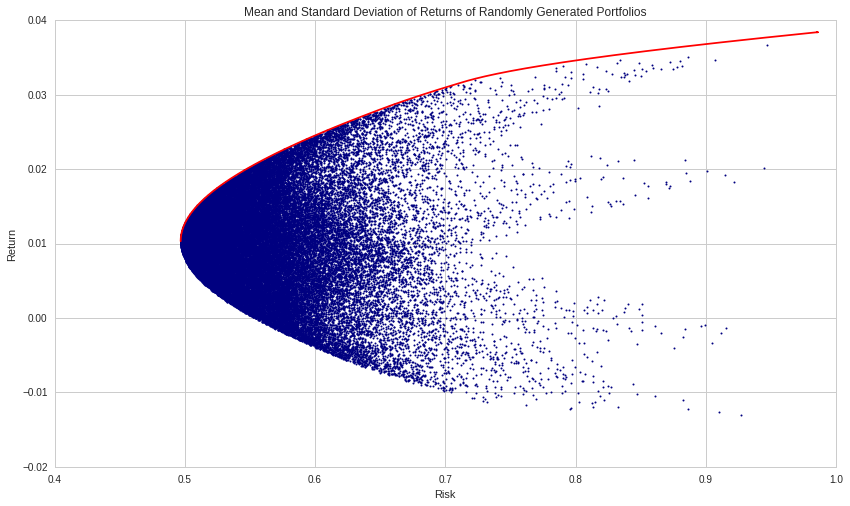

In [5]:
np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

# Number of assets
n_assets = 4

# Number of observations
n_obs = 2000

## Generating random returns for our 4 securities
return_vec = np.random.randn(n_assets, n_obs)

def rand_weights(n):
    ''' 
    Produces n random weights that sum to 1 
    '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

def optimal_portfolios(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100000
    
    # Creating a list of returns to optimize the risk for
    mus = [100**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## Calculate the risk and returns of the frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    return returns, risks

n_portfolios = 50000

means, stds = np.column_stack([random_portfolio(return_vec) for x in range(n_portfolios)])

returns, risks = optimal_portfolios(return_vec)

plt.plot(stds, means, 'o', markersize=2, color='navy')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation of Returns of Randomly Generated Portfolios');

plt.plot(risks, returns, '-', markersize=3, color='red');

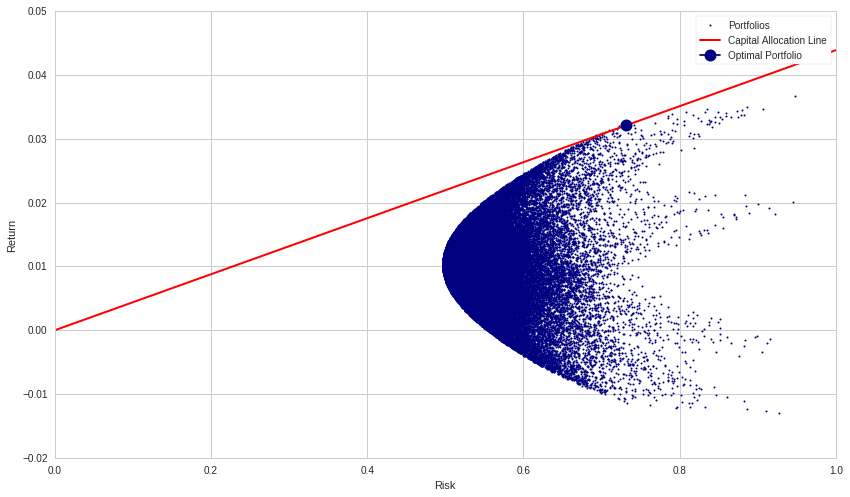

In [6]:
def maximize_sharpe_ratio(return_vec, risk_free_rate):
    """
    Finds the CAPM optimal portfolio from the efficient frontier 
    by optimizing the Sharpe ratio.
    """
    
    def find_sharpe(weights):
        
        means = [np.mean(asset) for asset in return_vec]
        
        numerator = sum(weights[m]*means[m] for m in range(len(means))) - risk_free_rate
        
        weight = np.array(weights)
        
        denominator = np.sqrt(weights.T.dot(np.corrcoef(return_vec).dot(weights)))
        
        return numerator/denominator
    
    guess = np.ones(len(return_vec)) / len(return_vec)
    
    def objective(weights):
        return -find_sharpe(weights)
    
    # Set up equality constrained
    cons = {'type':'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1} 

    # Set up bounds for individual weights
    bnds = [(0, 1)] * len(return_vec)
    
    results = optimize.minimize(objective, guess,
                            constraints=cons, bounds=bnds, 
                            method='SLSQP', options={'disp': False})
    
    return results

risk_free_rate = np.mean(R_F)

results = maximize_sharpe_ratio(return_vec, risk_free_rate)

# Applying the optimal weights to each assset to get build portfolio
optimal_mean = sum(results.x[i]*np.mean(return_vec[i]) for i in range(len(results.x)))

optimal_std = np.sqrt(results.x.T.dot(np.corrcoef(return_vec).dot(results.x)))

# Plot of all possible portfolios
plt.plot(stds, means, 'o', markersize=2, color='navy')
plt.ylabel('Return')
plt.xlabel('Risk')

# Line from the risk-free rate to the optimal portfolio
eqn_of_the_line = lambda x : ( (optimal_mean-risk_free_rate) / optimal_std ) * x + risk_free_rate    

xrange = np.linspace(0., 1., num=11)

plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='red', linestyle='-', linewidth=2)

# Our optimal portfolio
plt.plot([optimal_std], [optimal_mean], marker='o', markersize=12, color="navy")

plt.legend(['Portfolios', 'Capital Allocation Line', 'Optimal Portfolio'])

To demonstrate the power of diversification, we can look at the how the returns and risk of the individual assets compare to the optimal portfolio we found.

In [7]:
for a in range(len(return_vec)): 
    print "Return and Risk of Asset", a, ":", np.mean(return_vec[a]), ",",np.std(return_vec[a])   
    
print "Return and Risk of Optimal Portfolio", optimal_mean, optimal_std

Return and Risk of Asset 0 : -0.0155874843425 , 0.979925446819
Return and Risk of Asset 1 : 0.0384158887148 , 0.985658403299
Return and Risk of Asset 2 : 0.0206467377992 , 0.991949738581
Return and Risk of Asset 3 : -0.00443686547651 , 1.00311968218
Return and Risk of Optimal Portfolio 0.0321127409574 0.73112973553


The above assumptions are general to models in the mean-variance framework. Beyond that, CAPM makes the additional assumption that all investors have homogenous beliefs. The implication of this is that they are all mean-variance optimizers and that they would all demand the same tangent portfolio. If we were to accumulate the portfolios of all investors we would end up with the market portfolio, since all shares must be held by someone. This must mean that the tangency portfolio is the market portfolio. Notice that this statement is essentially the same as saying demand must equal supply.

When a risk-free asset is added to the portfolio, given that the CAPM assumptions hold, the CAL turns into the Capital Market Line. According to the CAPM, any stock or portfolio that lies to the right of CML would contain diversifiable risk and is therefore not efficient.

The mapping of each security's beta to its expected return results in the Security Markets Line. The difference between a security's return and the expected return as predicted by CAPM is known as the alpha.

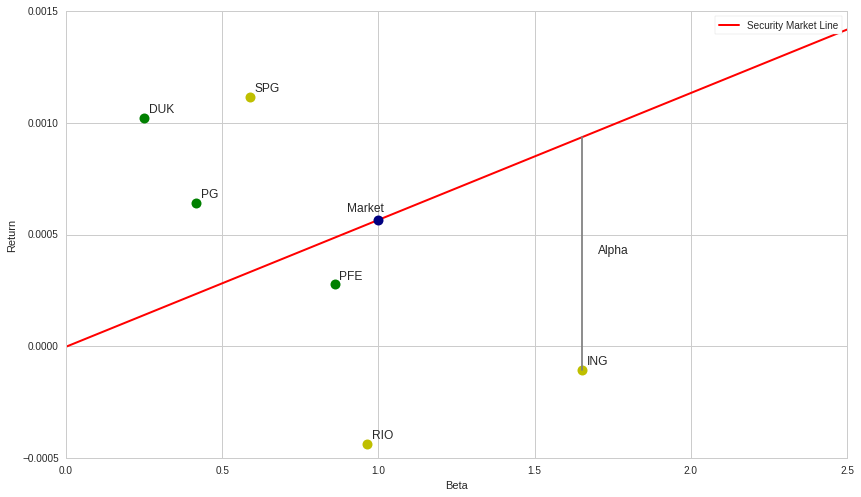

In [8]:
risk_free_rate = np.mean(R_F)

# We have two coordinates that we use to map the SML: (0, risk-free rate) and (1, market return)

eqn_of_the_line = lambda x : ( (np.mean(M)-risk_free_rate) / 1.0) * x + risk_free_rate        
xrange = np.linspace(0., 2.5, num=2)
plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='red', linestyle='-', linewidth=2)

plt.plot([1], [np.mean(M)], marker='o', color='navy', markersize=10)
plt.annotate('Market', xy=(1, np.mean(M)), xytext=(0.9, np.mean(M)+0.00004))

# Next, we will compare to see whether stocks in more cyclical industries have higher betas
# Of course, a more thorough analysis is required to rigorously answer this question

# Non-Cyclical Industry Stocks
non_cyclical = ['PG', 'DUK', 'PFE']
non_cyclical_returns = [get_pricing(asset, fields='price', start_date=start_date, end_date=end_date).pct_change()[1:] for asset in non_cyclical]
non_cyclical_betas = [regression.linear_model.OLS(R, sm.add_constant(M)).fit().params[1] for R in non_cyclical_returns]

for asset, R, beta in zip(non_cyclical, non_cyclical_returns, non_cyclical_betas):
    plt.plot([beta], [np.mean(R)], marker='o', color='g', markersize=10)
    plt.annotate(asset, xy=(beta, np.mean(R)), xytext=(beta + 0.015, np.mean(R) + 0.000025))

# Cyclical Industry Stocks
cyclical = ['RIO', 'SPG', 'ING']
cyclical_returns = [get_pricing(asset, fields='price', start_date=start_date, end_date=end_date).pct_change()[1:] for asset in cyclical]
cyclical_betas = [regression.linear_model.OLS(R, sm.add_constant(M)).fit().params[1] for R in cyclical_returns]

for asset, R, beta in zip(cyclical, cyclical_returns, cyclical_betas):
    plt.plot([beta], [np.mean(R)], marker='o', color='y', markersize=10)
    plt.annotate(asset, xy=(beta, np.mean(R)), xytext=(beta + 0.015, np.mean(R) + 0.000025))

# drawing the alpha, which is the difference between expected return and the actual return
plt.plot([cyclical_betas[2], cyclical_betas[2]], [np.mean(cyclical_returns[2]), eqn_of_the_line(cyclical_betas[2])], color='grey')
plt.annotate('Alpha', xy=(cyclical_betas[2] + 0.05, (eqn_of_the_line(cyclical_betas[2]) - np.mean(cyclical_returns[2]))/2 + np.mean(cyclical_returns[2])),
            xytext=(cyclical_betas[2] + 0.05, (eqn_of_the_line(cyclical_betas[2]) - np.mean(cyclical_returns[2]))/2 + np.mean(cyclical_returns[2])))

plt.xlabel("Beta")
plt.ylabel("Return")

plt.legend(['Security Market Line'])

The above was a very high level description of CAPM. For a more detailed derivation, check out the [wiki page](https://en.wikipedia.org/wiki/Capital_asset_pricing_model)!

# Arbitrage Pricing Theory

CAPM, while being a fundamental theory, has many drawbacks. With strict, limiting assumptions it doesn't hold up well in empirical tests. The Arbitrage Pricing Theory aims to generalize the CAPM model on the basis that assets may be exposed to classes of risks other than the market risk and that investors may care about things other than just the mean and variance.

APT is a major asset pricing theory that relies on expressing the returns using a linear factor model:

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$

A factor is a return stream that is determined completely by some characteristic. For example, CAPM has only one factor which is the market return.

This theory states that if we have modelled our rate of return as above, then the expected returns obey

$$ E(R_i) = R_F + b_{i1} \lambda_1 + b_{i2} \lambda_2 + \ldots + b_{iK} \lambda_K $$

where $R_F$ is the risk-free rate, and $\lambda_j$ is the risk premium - the return in excess of the risk-free rate - for factor $j$. This premium arises because investors require higher returns to compensate them for incurring risk. This generalizes the capital asset pricing model (CAPM), which uses the return on the market as its only factor.

We'll compute the risk premia for our factors with Fama-Macbeth regression. However, there are various ways to compute each $\lambda$!

## Arbitrage

There are generally many, many securities in our universe. If we use different ones to compute the $\lambda$s, will our results be consistent? If our results are inconsistent, there is an <i>arbitrage opportunity</i> (in expectation). Arbitrage is an operation that earns a profit without incurring risk and with no net investment of money. In this case, we mean that there is a risk-free operation with <i>expected</i> positive return that requires no net investment. It occurs when expectations of returns are inconsistent, i.e. risk is not priced consistently across securities.

For instance, there is an arbitrage opportunity in the following case: say there is an asset with expected rate of return 0.2 for the next year and a $\beta$ of 1.2 with the market, while the market is expected to have a rate of return of 0.1, and the risk-free rate on 1-year bonds is 0.05. Then the APT model tells us that the expected rate of return on the asset should be

$$ R_F + \beta \lambda = 0.05 + 1.2 (0.1 - 0.05) = 0.11$$

This does not agree with the prediction that the asset will have a rate of return of 0.2. So, if we buy \$100 of our asset, short \$120 of the market, and buy \$20 of bonds, we will have invested no net money and are not exposed to any systematic risk (we are market-neutral), but we expect to earn $0.2(100) - 0.1(120) + 0.05(20) = 9$ dollars at the end of the year.

The APT assumes that these opportunities will be taken advantage of until prices shift and the arbitrage opportunities disappear. That is, it assumes that there are arbitrageurs who have sufficient amounts of patience and capital. This provides a justification for the use of empirical factor models in pricing securities: if the model was inconsistent, there would be an arbitrage opportunity, and so the prices would adjust.

##Goes Both Ways

Often knowing $E(R_i)$ is incredibly difficult, but notice that this model tells us what the expected returns should be if the market is fully arbitraged. This lays the groundwork for long-short equity strategies based on factor model ranking systems. If you know what the expected return of an asset is given that the market is arbitraged, and you hypothesize that the market will be mostly arbitraged over the timeframe on which you are trading, then you can construct a ranking.

##Long-Short Equity

To do this, estimate the expected return for each asset on the market, then rank them. Long the top percentile and short the bottom percentile, and you will make money on the difference in returns. Said another way, if the assets at the top of the ranking on average tend to make $5\%$ more per year than the market, and assets at the bottom tend to make $5\%$ less, then you will make $(M + 0.05) - (M - 0.05) = 0.10$ or $10\%$ percent per year, where $M$ is the market return that gets canceled out.

Long-short equity accepts that any individual asset is very difficult to model, relies on broad trends holding true. We can't accurately predict expected returns for an asset, but we can predict the expected returns for a group of 1000 assets as the errors average out.

## Empirical Tests

Most empirical tests of the APT are done in two steps: estimating the betas of individual factors, then comparing it to actual prices to see how predictions fared.

In our example of APT, we will use the return streams from Long-Short equity strategies built from various microeconomic indicators as our factors. Then, we'll use the Fama-Macbeth regression method to estimate our risk premia. Our factor analysis lecture provides an in-depth description of choosing factors.

We'll begin by importing relevant libraries.

In [47]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import Returns, Latest
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.research import run_pipeline
from quantopian.pipeline.classifiers.morningstar import Sector
import itertools

Next, we'll use pipeline to get all of our data.

In [86]:
def make_pipeline():
    
    pipe = Pipeline()

    # Add our factors to the pipeline
    purchase_of_biz = Latest([morningstar.cash_flow_statement.purchase_of_business])
    pipe.add(purchase_of_biz, 'purchase_of_business')
    
    RD = Latest([morningstar.income_statement.research_and_development])
    pipe.add(RD, 'RD')
    
    operating_cash_flow = Latest([morningstar.cash_flow_statement.operating_cash_flow])
    pipe.add(operating_cash_flow, 'operating_cash_flow')
    
    # Create factor rankings and add to pipeline
    purchase_of_biz_rank = purchase_of_biz.rank()
    RD_rank = RD.rank()
    operating_cash_flow_rank = operating_cash_flow.rank()

    pipe.add(purchase_of_biz_rank, 'purchase_of_biz_rank')
    pipe.add(RD_rank, 'RD_rank')
    pipe.add(operating_cash_flow_rank, 'operating_cash_flow_rank')
    
    most_biz_bought = purchase_of_biz_rank.top(1000)
    least_biz_bought = purchase_of_biz_rank.bottom(1000)
    
    most_RD = RD_rank.top(1000)
    least_RD = RD_rank.bottom(1000)
    
    most_cash = operating_cash_flow_rank.top(1000)
    least_cash = operating_cash_flow_rank.bottom(1000)
    
    pipe.add(most_biz_bought, 'most_biz_bought')
    pipe.add(least_biz_bought, 'least_biz_bought')
    
    pipe.add(most_RD, 'most_RD')
    pipe.add(least_RD, 'least_RD')
    
    pipe.add(most_cash, 'most_cash')
    pipe.add(least_cash, 'least_cash')
    
    # We also get daily returns
    returns = Returns(window_length=2)
    
    # and sector types
    sectors = Sector()

    pipe.add(returns, "Returns")
    
    # We will focus on technology stocks in the Q1500
    pipe.set_screen((Q1500US() & sectors.eq(311)) & 
                    most_biz_bought | least_biz_bought | 
                    most_RD | least_RD |
                    most_cash | least_cash)
    
    return pipe

pipe = make_pipeline()
results = run_pipeline(pipe, start_date, end_date)

results

RD  RD_rank  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])         4.400000e+07   1452.0   
                          Equity(24 [AAPL])        1.168000e+09   1654.0   
                          Equity(25 [ARNC_PR])     4.400000e+07   1453.0   
                          Equity(31 [ABAX])        3.418000e+06    684.0   
                          Equity(52 [ABM])                  NaN      NaN   
                          Equity(53 [ABMD])        7.721000e+06    983.0   
                          Equity(62 [ABT])         3.568770e+08   1626.0   
                          Equity(64 [ABX])         2.600000e+07   1351.0   
                          Equity(66 [AB])                   NaN      NaN   
                          Equity(67 [ADSK])        1.490000e+08   1569.0   
                          Equity(69 [ACAT])        6.286000e+06    893.0   
                          Equity(76 [TAP])         3.998000e+06    732.0   
                          Equity(84 [ACET])        5.540000e+05    236.0   
                          Equity(88 [ACI])                  NaN      NaN   
                          Equity(100 [IEP])                 NaN      NaN   
                          Equity(114 [ADBE])       2.051960e+08   1589.0   
                          Equity(122 [ADI])        1.310340e+08   1557.0   
                          Equity(128 [ADM])                 NaN      NaN   
                          Equity(161 [AEP])                 NaN      NaN   
                          Equity(162 [AEPI])                NaN      NaN   
                          Equity(166 [AES])                 NaN      NaN   
                          Equity(168 [AET])                 NaN      NaN   
                          Equity(185 [AFL])                 NaN      NaN   
                          Equity(197 [AGCO])       8.730000e+07   1528.0   
                          Equity(205 [AGN])        2.576000e+08   1606.0   
                          Equity(216 [HES])                 NaN      NaN   
                          Equity(239 [AIG])                 NaN      NaN   
                          Equity(247 [AIN])        1.334700e+07   1170.0   
                          Equity(266 [AJG])                 NaN      NaN   
                          Equity(270 [AKRX])       4.837000e+06    799.0   
...                                                         ...      ...   
2014-12-31 00:00:00+00:00 Equity(47980 [BOOT])              NaN      NaN   
                          Equity(48009 [LBRD_A])   4.688000e+06    825.0   
                          Equity(48010 [LBRD_K])   4.688000e+06    826.0   
                          Equity(48025 [NVRO])     5.236000e+06    875.0   
                          Equity(48026 [CHRS])     1.849600e+07   1371.0   
                          Equity(48029 [UPLD])     3.793000e+06    739.0   
                          Equity(48030 [COF_PRD])           NaN      NaN   
                          Equity(48037 [AINC])              NaN      NaN   
                          Equity(48054 [GAIN_O])            NaN      NaN   
                          Equity(48065 [AXTA])     1.340000e+07   1259.0   
                          Equity(48073 [CRC])               NaN      NaN   
                          Equity(48079 [SLNO])     7.170000e+05    293.0   
                          Equity(48088 [FGEN])     4.061700e+07   1563.0   
                          Equity(48090 [NDRM])     1.308000e+06    438.0   
                          Equity(48104 [PGRE])              NaN      NaN   
                          Equity(48113 [EYES])     1.419992e+06    452.0   
                          Equity(48127 [NEOT])     1.711999e+06    506.0   
                          Equity(48132 [SKIS])              NaN      NaN   
                          Equity(48134 [CRDS_H])   1.276000e+06    430.0   
                          Equity(48143 [PSA_PRA])           NaN      NaN   
                          Equity(48171 [HSGX])     1.323700e+07   1255.0   
                          Equity(

To get our factor return streams, we will rank equities based on their purchases of businesses, their R&D spending, and their cash flow. Then, for each indicator, we'll go long the assets in the top percentile and short the ones in the bottom. 

In [ ]:
most_biz_bought = results[results.most_biz_bought]['Returns'].groupby(level=0).mean()
least_biz_bought = results[results.least_biz_bought]['Returns'].groupby(level=0).mean()

most_RD = results[results.most_RD]['Returns'].groupby(level=0).mean()
least_RD = results[results.least_RD]['Returns'].groupby(level=0).mean()

most_cash = results[results.most_cash]['Returns'].groupby(level=0).mean()
least_cash = results[results.least_cash]['Returns'].groupby(level=0).mean()

# Calculating our factor return streams
biz_purchase_portfolio = most_biz_bought - least_biz_bought
RD_portfolio = most_RD - least_RD
cash_flow_portfolio = most_cash - least_cash

Finally, we'll put everything together in our Fama-Macbeth regressions. This occurs in two steps.

First, for each asset we'll regress the its returns on the return streams of all the factors.

$$R_{1, t} = \alpha_1 + \beta_{1, F_1}F_{1, t} + \beta_{1, F_2}F_{2, t} + \dots + \beta_{1, F_m}F_{m, t} + \epsilon_{1, t}$$
$$R_{2, t} = \alpha_2 + \beta_{2, F_1}F_{1, t} + \beta_{2, F_2}F_{2, t} + \dots + \beta_{2, F_m}F_{m, t} + \epsilon_{2, t}$$
$$\vdots$$
$$R_{n, t} = \alpha_n + \beta_{n, F_1}F_{1, t} + \beta_{n, F_2}F_{2, t} + \dots + \beta_{n, F_m}F_{m, t} + \epsilon_{n, t}$$

Second, we'll take all of the beta estimates we got from the first step and use those as our exogenous variables in an estimate of the mean return of each assets. Note: we are estimating our risk premia in this step, the $\gamma$s.
$$E(R_i) = \gamma_0 + \gamma_1 \hat{\beta}_{i, F_1} + \gamma_2 \hat{\beta}_{i, F_2} + \dots + \gamma_m \hat{\beta}_{i, F_m} + \epsilon_i$$

In [88]:
# putting all of our data from pipeline into a DataFrame for convenience
# we'll have to first do some data manipulating since our factor return streams are date specific,
# but our asset returns are both date and asset specific

data = results[['Returns']].set_index(results.index)
asset_list_sizes = [group[1].size for group in data.groupby(level=0)]

purchase_of_biz_column = [ [ biz_purchase_portfolio.loc[group[0]] ] * size for group, size in zip(data.groupby(level=0), asset_list_sizes)]
data['Purchase of Business'] = list(itertools.chain(*purchase_of_biz_column))

RD_column = [ [ RD_portfolio.loc[group[0]] ] * size for group, size in zip(data.groupby(level=0), asset_list_sizes)]
data['RD'] = list(itertools.chain(*RD_column))

cash_flow_column = [ [ cash_flow_portfolio.loc[group[0]] ] * size for group, size in zip(data.groupby(level=0), asset_list_sizes)]
data['Operating Cash Flow'] = list(itertools.chain(*cash_flow_column))

data = sm.add_constant(data.dropna())

# Our list of assets from pipeline
assets = data.index.levels[1].unique()

X = [data.xs(asset, level=1)['Returns'] for asset in assets] 
Y = [data.xs(asset, level=1)[['Purchase of Business', 'RD', 'Operating Cash Flow', 'const']] for asset in assets]

# First regression step: estimating the betas
reg_results = [regression.linear_model.OLS(x-risk_free_rate, y).fit().params for x, y in zip(X, Y) if not(x.empty or y.empty)]
indices = [asset for x, y, asset in zip(X, Y, assets) if not(x.empty or y.empty)]

betas = pd.DataFrame(reg_results, index=indices)
betas = sm.add_constant(betas.drop('const', axis=1))

R = data['Returns'].mean(axis=0, level=1)

# Second regression step: estimating the risk premia
final_results = regression.linear_model.OLS(R - risk_free_rate, betas).fit()

final_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     89.15
Date:                Wed, 21 Jun 2017   Prob (F-statistic):           5.55e-56
Time:                        21:29:37   Log-Likelihood:                 17796.
No. Observations:                4352   AIC:                        -3.558e+04
Df Residuals:                    4348   BIC:                        -3.556e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                    0.0001    8.2e-05      1.664      0.096     -2.43e-05     0.000
Purchase of Business     0.0003    2.6e-05     12.566      0.000         0.000     0.000
RD                      -0.0003   3.38e-05     -9.667      0.000        -0.000    -0.000
Operating Cash Flow     -0.0005    6.2e-05     -7.372      0.000        -0.001    -0.000
==============================================================================
Omnibus:                     4096.743   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1917787.193
Skew:                          -3.655   Prob(JB):                         0.00
Kurtosis:                     105.580   Cond. No.                         9.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It is imperative that we not just use our model estimates at face value. A scan through the accompanying statistics can be highly insightful about the efficacy of our estimated model. For example, notice that although our individual factors are significant, we have a very low $R^2$. What this may suggest is that there is a real link between our factors and the returns of our assets, but that there still remains a lot of unexplained noise!

For a more in-depth look at choosing factors, check out the [factor analysis lecture](https://www.quantopian.com/lectures/factor-analysis)!

In [82]:
# smoke test for multicollinearity
print data[['Purchase of Business', 'RD', 'Operating Cash Flow']].corr()

                      Purchase of Business        RD  Operating Cash Flow
Purchase of Business              1.000000 -0.012497            -0.565368
RD                               -0.012497  1.000000            -0.077220
Operating Cash Flow              -0.565368 -0.077220             1.000000


Now that we have estimates for our risk premia we can combine these with our beta estimates from our original regression to estimate asset returns.

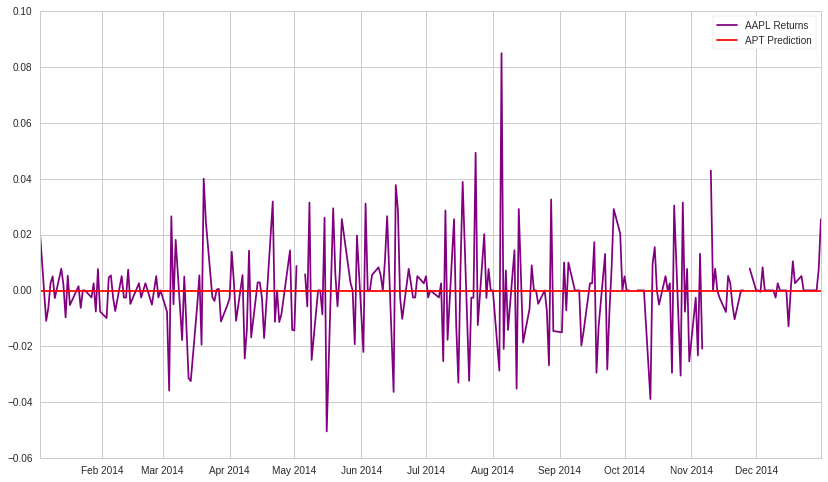

In [90]:
# this is our actual model!
expected_return = risk_free_rate \
    + betas['Purchase of Business']*final_results.params[1] \
    + betas['RD']*final_results.params[2] \
    + betas['Operating Cash Flow']*final_results.params[3]

year_of_returns = get_pricing(expected_return.index, start_date, end_date, fields='close_price').pct_change()[1:]

plt.plot(year_of_returns[expected_return.index[1]], color='purple')
plt.plot(pd.DataFrame({'Expected Return': expected_return.iloc[0]}, index=year_of_returns.index), color='red')
plt.legend(['AAPL Returns', 'APT Prediction'])


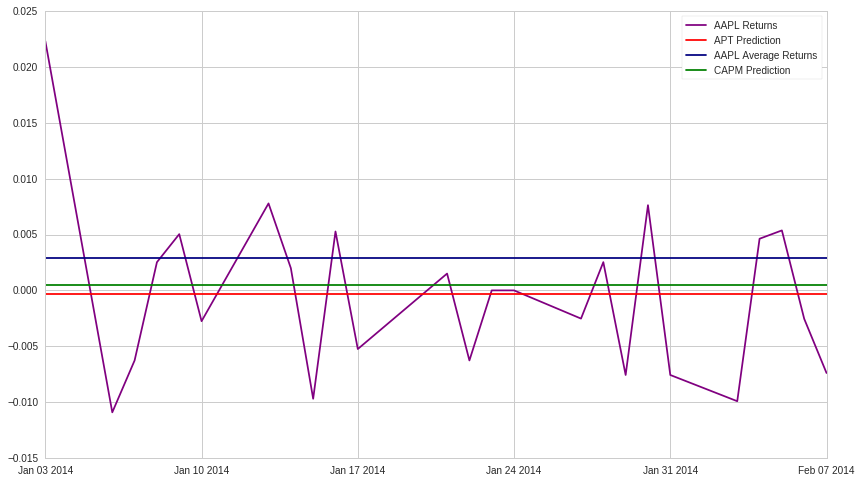

In [84]:
# Compare AAPL prediction of CAPM vs. our APT model
M_annual_return = get_pricing('SPY', start_date=start_date, end_date=end_date, fields='price').pct_change()[1:]

# We'll take the market beta we calculated from the beginning of the lecture
CAPM_AAPL_prediction = risk_free_rate + AAPL_beta*(M_annual_return.mean() - risk_free_rate)

# Let's take a closer look
year_of_returns = year_of_returns[:25]

plt.plot(year_of_returns[expected_return.index[1]], color='purple')
plt.plot(pd.DataFrame({'Expected Return': expected_return.iloc[0]}, index=year_of_returns.index), color='red')
plt.plot(pd.DataFrame({'Expected Return': year_of_returns.mean()[0]}, index=year_of_returns.index), color='navy')
plt.plot(pd.DataFrame({'Expected Return': CAPM_AAPL_prediction}, index=year_of_returns.index), color='green')
plt.legend(['AAPL Returns', 'APT Prediction', 'AAPL Average Returns', 'CAPM Prediction'])


Finally, as a rough comparison between APT and CAPM, we'll look at the returns from Long-Short strategies constructed using each model as the ranking scheme.

Returns after a year: APT versus CAPM
1.69632235509


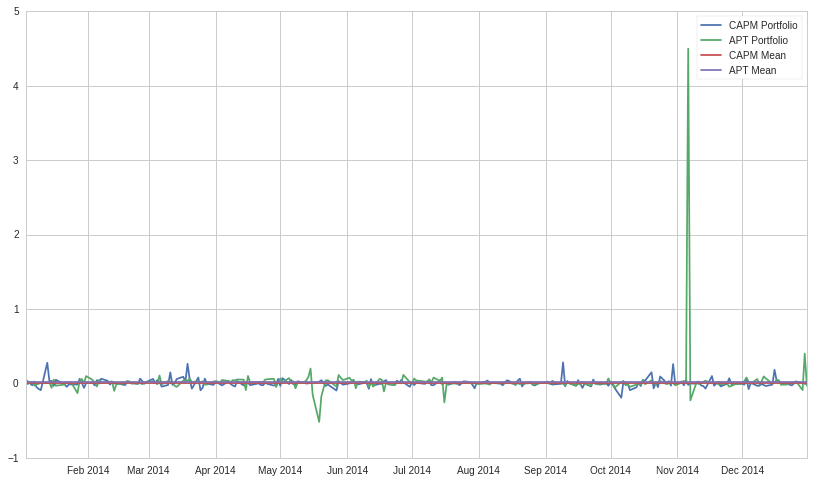

In [89]:
market_betas = [regression.linear_model.OLS(x[1:], sm.add_constant(M_annual_return)).fit().params[1] for x in X if (x[1:].size == M_annual_return.size)]
indices = [asset for x, asset in zip(X, assets) if (x[1:].size == M_annual_return.size)]

market_return = pd.DataFrame({'Market': M_annual_return.mean()}, index = indices)

CAPM_predictions = risk_free_rate + market_betas*(market_return['Market'] - risk_free_rate)

CAPM_predictions.sort_values(inplace=True, ascending=False)

CAPM_portfolio = [CAPM_predictions.head(5).index, CAPM_predictions.tail(5).index]
CAPM_long = get_pricing(CAPM_portfolio[0], start_date=start_date, end_date=end_date, fields='price').pct_change()[1:].mean(axis=1)
CAPM_short = get_pricing(CAPM_portfolio[1], start_date=start_date, end_date=end_date, fields='price').pct_change()[1:].mean(axis=1)

CAPM_returns = CAPM_long - CAPM_short

expected_return.sort_values(inplace=True, ascending=False)

APT_portfolio = [expected_return.head(5).index, expected_return.tail(5).index]
APT_long = get_pricing(APT_portfolio[0], start_date=start_date, end_date=end_date, fields='price').pct_change()[1:].mean(axis=1)
APT_short = get_pricing(APT_portfolio[1], start_date=start_date, end_date=end_date, fields='price').pct_change()[1:].mean(axis=1)

APT_returns = APT_long - APT_short

plt.plot(CAPM_returns)
plt.plot(APT_returns)
plt.plot(pd.DataFrame({'Mean Return': CAPM_returns.mean()}, index=CAPM_returns.index))
plt.plot(pd.DataFrame({'Mean Return': APT_returns.mean()}, index=APT_returns.index))
plt.legend(['CAPM Portfolio', 'APT Portfolio', 'CAPM Mean', 'APT Mean'])

print "Returns after a year: APT versus CAPM"
print ((APT_returns[-1]/APT_returns[0]) - 1) - ((CAPM_returns[-1]/CAPM_returns[0])-1)
